# **Assignment 5**

### **Group 3** - Bethel Mandizha, Miranda Montenegro, Rahul Saha, Zeyu Wang

-----

Copyright 2021 - 2025 Patrick Hall (jphall@gwu.edu), Bethel Mandizha (bethel.mandizha@gwmail.gwu.edu), Miranda Montenegro (miranda.montenegrolopez@gwmail.gwu.edu), Rahul Saha (rahul.saha@gwmail.gwu.edu), & Zeyu Wang (zywang@gwu.edu)

Licensed under the Apache License, Version 2.0 (the "License"); you may not use this file except in compliance with the License. You may obtain a copy of the License at

http://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software distributed under the License is distributed on an "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied. See the License for the specific language governing permissions and limitations under the License.

DISCLAIMER: This notebook is not legal or compliance advice.

-----

### **Importing Necessary Libraries**

In [1]:
#Data manipulation, plotting and metrics
import numpy as np
import pandas as pd
import operator
import matplotlib.pyplot as plt
from sklearn import metrics
import seaborn as sns  
import datetime   
import time  

#Model modules
import xgboost as xgb  
import itertools 
from interpret import show
from interpret.glassbox import ExplainableBoostingClassifier
from interpret.perf import ROC 

#Setting numpy seed for better reproducibility
SEED = 12345 
np.random.seed(SEED)

#Setting number of threads
NTHREAD = 4

#### Starting the Global Timer

In [2]:
tic = time.time()

### **Importing Applicable Data**

In [3]:
#Importing pre-processed training data and showing first 5 lines of the dataset
train_data = pd.read_csv('/Users/Jing/Downloads/hmda_train_preprocessed.csv')
train_data.head()

,row_id,black,asian,white,amind,hipac,hispanic,non_hispanic,male,female,...,conforming,debt_to_income_ratio_missing,loan_amount_std,loan_to_value_ratio_std,no_intro_rate_period_std,intro_rate_period_std,property_value_std,income_std,debt_to_income_ratio_std,high_priced
0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,0.0,...,1,0,-0.514393,0.333922,0.244394,-0.215304,-0.535932,-0.040307,0.854601,0
1,1,0.0,0.0,1.0,0.0,0.0,0.0,1.0,NaN,NaN,...,1,0,-0.118642,0.268727,0.244394,-0.215304,-0.227585,-0.018133,-0.425131,0
2,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1,0,-0.778227,0.228996,-4.091747,4.610857,-0.720941,-0.032338,0.123326,0
3,3,0.0,0.0,1.0,0.0,0.0,0.0,1.0,NaN,NaN,...,1,0,-0.074670,-1.150240,0.244394,-0.215304,0.358276,-0.018133,-0.425131,0
4,4,0.0,0.0,1.0,0.0,0.0,1.0,0.0,NaN,NaN,...,1,0,-0.602338,0.552520,0.244394,-0.215304,-0.628437,-0.038228,0.763191,0


In [4]:
#Importing pre-processed testing data and showing first 5 lines of the dataset
test_data = pd.read_csv('/Users/Jing/Downloads/hmda_test_preprocessed.csv')
test_data.head()

,row_id,black,asian,white,amind,hipac,hispanic,non_hispanic,male,female,...,term_360,conforming,debt_to_income_ratio_missing,loan_amount_std,loan_to_value_ratio_std,no_intro_rate_period_std,intro_rate_period_std,property_value_std,income_std,debt_to_income_ratio_std
0,0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,...,1,1,0,-0.514393,-0.039293,0.244394,-0.215304,-0.474263,-0.017786,0.854601
1,1,0.0,0.0,1.0,0.0,0.0,NaN,NaN,NaN,NaN,...,1,1,0,-0.162614,0.126830,0.244394,-0.215304,-0.227585,-0.015014,-0.425131
2,2,NaN,NaN,NaN,NaN,NaN,1.0,0.0,NaN,NaN,...,1,1,0,-0.646310,0.552520,0.244394,-0.215304,-0.659271,-0.033378,-0.425131
3,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1,0,0,3.662982,0.133614,0.244394,-0.215304,2.763389,0.025177,0.306144
4,4,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,...,1,1,0,-0.338504,0.552520,0.244394,-0.215304,-0.443428,-0.027834,0.306144


#### Assigning modeling roles for the data

In [5]:
#Setting target and features for the data
target = 'high_priced'
demographic_cols = ['black', 'asian','white', 'amind', 'hipac', 'hispanic', 'non_hispanic', 'male', 'female', 'agegte62', 'agelt62']
features = [col for col in train_data.columns if col not in demographic_cols + ['row_id',target]]

print('target =', target)
print('predictors =', features)

target = high_priced
predictors = ['term_360', 'conforming', 'debt_to_income_ratio_missing', 'loan_amount_std', 'loan_to_value_ratio_std', 'no_intro_rate_period_std', 'intro_rate_period_std', 'property_value_std', 'income_std', 'debt_to_income_ratio_std']


### **Fitting the Data**

In [6]:
#Preserve exact reproducibility for this cell
np.random.seed(SEED) 

#Choosing a 70/30 train/test split 
split_ratio = 0.7

#Execute split
split = np.random.rand(len(train_data)) < split_ratio
train = train_data[split]
valid = train_data[~split]

#Summarize split
print('Train data rows = %d, columns = %d' % (train.shape[0], train.shape[1]))
print('Validation data rows = %d, columns = %d' % (valid.shape[0], valid.shape[1]))

Train data rows = 112253, columns = 23
Validation data rows = 48085, columns = 23


### Explainable Boosting Machine

#### Retrain most accurate model above 0.8 AIR to debug

In [7]:
# params dict for remediated models
rem_params = {'max_bins': 1024,
 'max_interaction_bins': 24,
 'interactions': 5,
 'outer_bags': 8,
 'inner_bags': 0,
 'learning_rate': 0.01,
 'validation_size': 0.05,
 'min_samples_leaf': 1,
 'max_leaves': 5,
 'n_jobs': NTHREAD,
 'early_stopping_rounds': 100,
 'random_state': SEED} # YOUR MODEL PARAMETERS HERE!

rem_x_names = ['intro_rate_period_std',
 'debt_to_income_ratio_std',
 'term_360',
 'property_value_std',
 'income_std',
 'debt_to_income_ratio_missing'] # YOUR FEATURES HERE!

# reset some parameters to integers
rem_params['random_state'] = int(rem_params['random_state'])
rem_params['n_jobs'] = int(rem_params['n_jobs'])
rem_params['early_stopping_rounds'] = int(rem_params['early_stopping_rounds'])

# retrain
rem_ebm = ExplainableBoostingClassifier(**rem_params)
rem_ebm.fit(train[rem_x_names], train[target])
rem_ebm_perf = ROC(rem_ebm.predict_proba).explain_perf(valid[rem_x_names], valid[target])
rem_auc = rem_ebm_perf._internal_obj['overall']['auc']
print('Remediated EBM retrained with AUC: %.4f.' % rem_auc)

Remediated EBM retrained with AUC: 0.7815.


### Sensitivity Analysis: Stress Testing

#### Simulate recession conditions in validation data

C:\Users\Jing\AppData\Local\Temp\ipykernel_15316\1947458325.py:25: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[0. 0. 0. ... 0. 0. 0.]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  rec_valid.loc[affected, 'debt_to_income_ratio_missing'] = rec_valid.loc[affected, 'debt_to_income_ratio_missing'] * 1.05


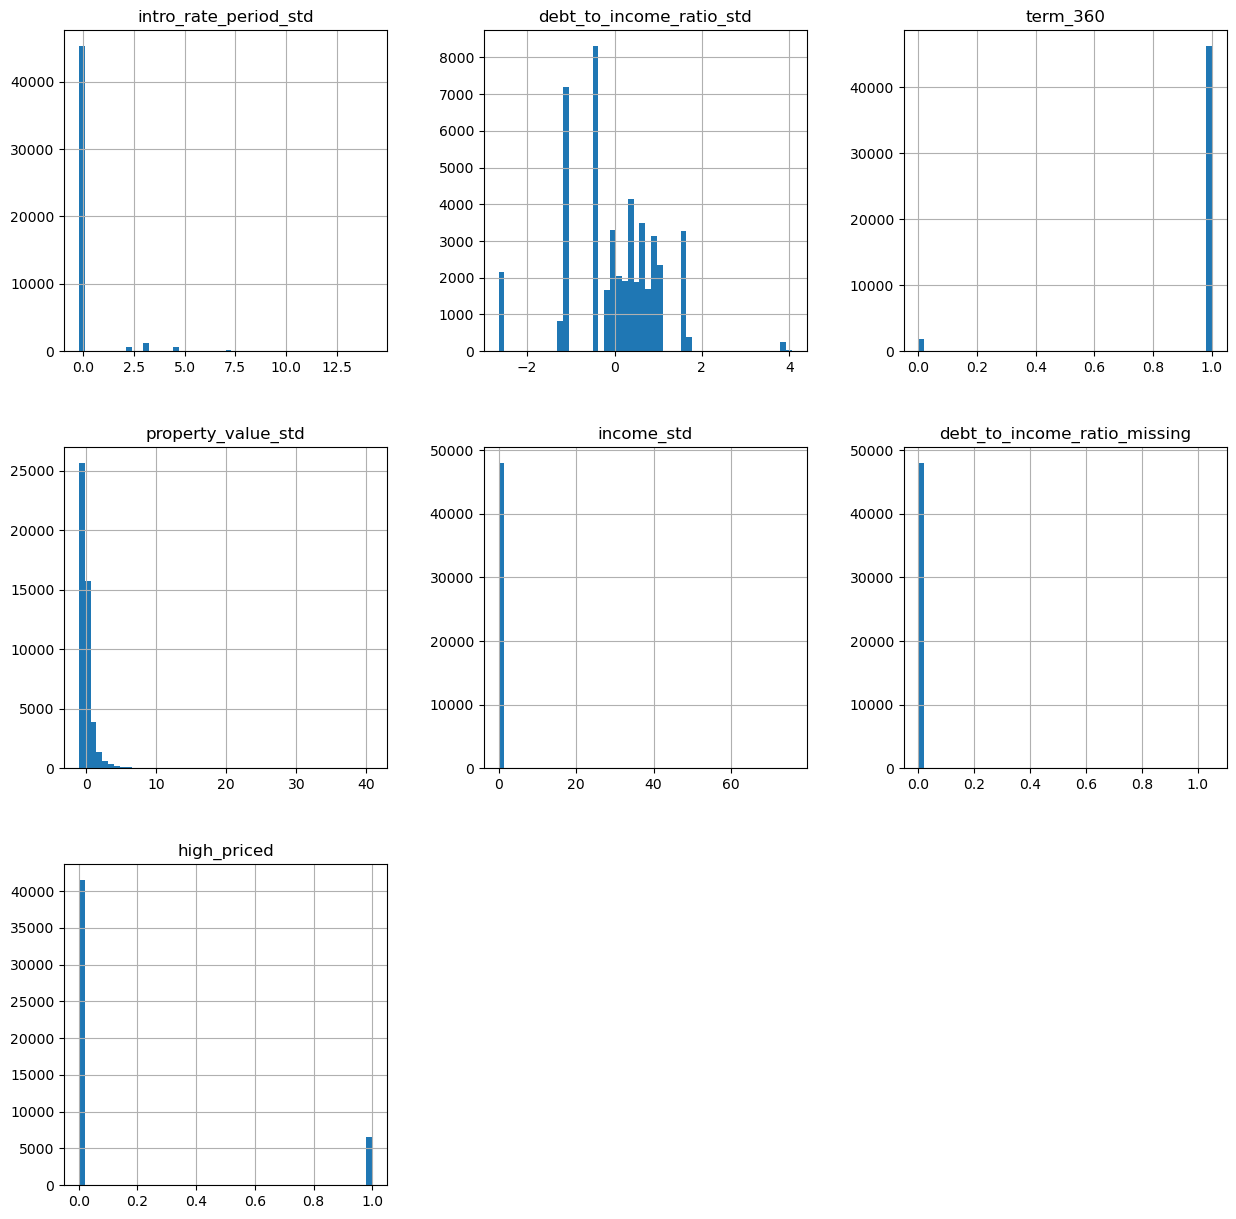

In [9]:
np.random.seed(SEED) 

rec_valid = valid.copy(deep=True) 

#Use severity variable to control how many customers are affected
severity = 0.1
affected = np.random.rand(len(rec_valid)) < severity

#Shorter intro rate periods
rec_valid.loc[affected, 'intro_rate_period_std'] = rec_valid.loc[affected, 'intro_rate_period_std'] * 0.95

#5% higher debt-to-income ratios
rec_valid.loc[affected, 'debt_to_income_ratio_std'] = rec_valid.loc[affected, 'debt_to_income_ratio_std'] * 1.05

#More long loans
rec_valid.loc[affected, 'term_360'] = 1

#Decrease property values by 5%
rec_valid.loc[affected, 'property_value_std'] = rec_valid.loc[affected, 'property_value_std'] * 0.95

#lower income by 5%
rec_valid.loc[affected, 'income_std'] = rec_valid.loc[affected, 'income_std'] * 0.95

#5% higher debt-to-income ratios missing
rec_valid.loc[affected, 'debt_to_income_ratio_missing'] = rec_valid.loc[affected, 'debt_to_income_ratio_missing'] * 1.05

#Update target
rec_valid.loc[affected, target] = np.random.choice(2, len(rec_valid.loc[affected, target]))

#Visualize results
_ = rec_valid[rem_x_names + [target]].hist(bins=50, figsize=(15, 15))

#### Find AUC for best model in simulated recession conditions

In [10]:
rec_rem_ebm_perf = ROC(rem_ebm.predict_proba).explain_perf(rec_valid[rem_x_names], rec_valid[target])
rec_rem_auc = rec_rem_ebm_perf._internal_obj['overall']['auc']
print('Remediated EBM retrained with AUC: %.4f.' % rec_rem_auc)

Remediated EBM retrained with AUC: 0.6940.


### Residual Analysis

#### Calculate predictions and logloss residuals for all data

In [11]:
# shortcut names
yhat_name = 'phat'
r_name = 'r'

# calculate predictions
rem_ebm_phat = pd.DataFrame(rem_ebm.predict_proba(train_data[rem_x_names])[:, 1], columns=['phat'])
rem_ebm_phat = pd.concat([train_data.reset_index(drop=True), rem_ebm_phat], axis=1)

# calculate logloss residuals
rem_ebm_phat[r_name] = -rem_ebm_phat[target]*np.log(rem_ebm_phat[yhat_name]) -\
                       (1 - rem_ebm_phat[target])*np.log(1 - rem_ebm_phat[yhat_name])

#### Plot residuals

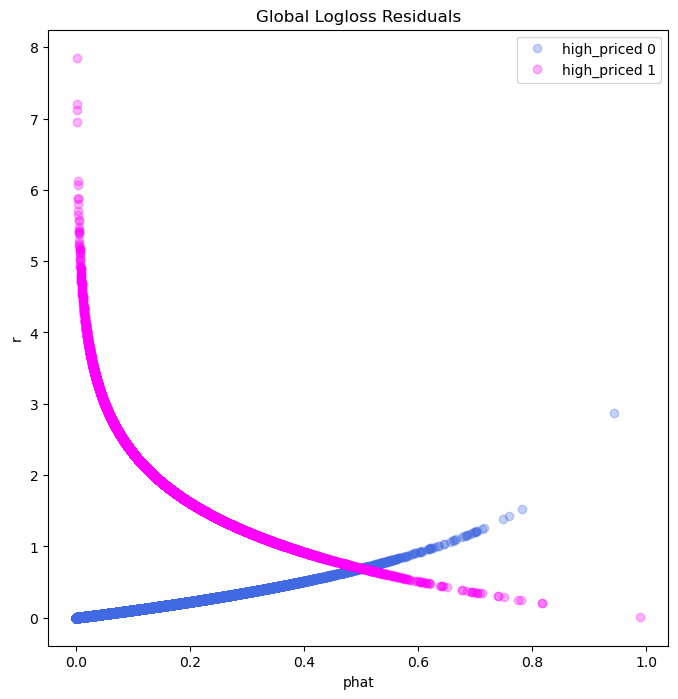

In [12]:
# initialize figure
fig, ax_ = plt.subplots(figsize=(8, 8))

# plot groups with appropriate color
color_list = ['royalblue', 'magenta']
c_idx = 0
groups = rem_ebm_phat.groupby(target) # define groups for levels of PAY_0
for name, group in groups:
    ax_.plot(group.phat, group.r,
             label=' '.join([target, str(name)]),
             marker='o', linestyle='', color=color_list[c_idx], alpha=0.3)
    c_idx += 1

# annotate plot
_ = plt.xlabel(yhat_name)
_ = plt.ylabel(r_name)
_ = ax_.legend(loc=1)
_ = plt.title('Global Logloss Residuals')

### Remediation: Remove Outliers

#### Find outliers

In [13]:
rem_ebm_phat.sort_values(by='r', ascending=False).head()

,row_id,black,asian,white,amind,hipac,hispanic,non_hispanic,male,female,...,loan_amount_std,loan_to_value_ratio_std,no_intro_rate_period_std,intro_rate_period_std,property_value_std,income_std,debt_to_income_ratio_std,high_priced,phat,r
66704,66704,0.0,0.0,1.0,0.0,0.0,0.0,1.0,NaN,NaN,...,0.716833,0.302372,-4.091747,14.263178,0.389111,-0.012935,0.854601,1,0.000389,7.852578
82041,82041,0.0,0.0,1.0,0.0,0.0,0.0,1.0,NaN,NaN,...,-0.954117,-2.973067,0.244394,-0.215304,0.697459,-0.052781,-0.425131,1,0.000749,7.196856
110822,110822,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,...,0.892723,-0.874794,0.244394,-0.215304,1.252485,-0.007738,-1.156406,1,0.000808,7.120847
71804,71804,0.0,0.0,1.0,0.0,0.0,0.0,1.0,NaN,NaN,...,0.409027,0.171903,-4.091747,4.610857,0.204102,-0.018133,0.214735,1,0.000954,6.955106
143877,143877,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,...,0.892723,-0.339083,0.244394,-0.215304,0.851633,-0.035110,1.037419,1,0.002181,6.128156


### Remediation and Model Evaluation Loop

In [14]:
# Remove worst outliers
fixed_n_removes = [5, 10, 15, 20, 25]

# Remediation: Down-sample to Increase Signal from High-priced Loans
inverse_proportion_remove = [2, 4]

results = []

configs = [(n, i) for n in fixed_n_removes for i in inverse_proportion_remove]

# Retrain remediated EBM and Test remediated EBM on true validation data
for num_remove, inv_prop in configs:
    rem_data = train_data.copy(deep=True)

    drop_indices = rem_ebm_phat.sort_values(by='r', ascending=False).head(num_remove).index
    rem_data.drop(drop_indices, axis=0, inplace=True)
    rem_type = f"Remove top {num_remove} samples"

    # Undersample negative class
    drop_neg_indices = rem_data[rem_data[target] == 0].index[::inv_prop]
    rem_data.drop(drop_neg_indices, axis=0, inplace=True)

    np.random.seed(SEED)
    split = np.random.rand(len(rem_data)) < split_ratio
    rem_train = rem_data[split]
    rem_valid = rem_data[~split]

    rem_ebm2 = ExplainableBoostingClassifier(**rem_params)
    rem_ebm2.fit(rem_train[rem_x_names], rem_train[target])

    # Under-sampled AUC
    rem_ebm_perf2 = ROC(rem_ebm2.predict_proba).explain_perf(rem_valid[rem_x_names], rem_valid[target])
    rem_auc2 = rem_ebm_perf2._internal_obj['overall']['auc']

    # True AUC
    rem_ebm_perf3 = ROC(rem_ebm2.predict_proba).explain_perf(valid[rem_x_names], valid[target])
    rem_auc3 = rem_ebm_perf3._internal_obj['overall']['auc']

    # Store results
    results.append({
        "Method": rem_type,
        "InvPropRemove": inv_prop,
        "Undersampled AUC": rem_auc2,
        "True AUC": rem_auc3
    })

#### Display and Sort AUCs

In [15]:
results_df = pd.DataFrame(results)
print(results_df.sort_values(by="True AUC", ascending=False).to_string(index=False))

               Method  InvPropRemove  Undersampled AUC  True AUC
Remove top 15 samples              4          0.778688  0.787933
Remove top 10 samples              2          0.776238  0.787870
Remove top 10 samples              4          0.778569  0.787828
 Remove top 5 samples              4          0.780253  0.787822
Remove top 25 samples              4          0.786278  0.787658
Remove top 20 samples              4          0.783499  0.787376
Remove top 15 samples              2          0.775796  0.787361
Remove top 20 samples              2          0.777871  0.787090
Remove top 25 samples              2          0.777813  0.786859
 Remove top 5 samples              2          0.779332  0.786706


#### Display Best Remediation Strategy

In [16]:
best_row = results_df.loc[results_df["True AUC"].idxmax()]
print("Best Remediation Strategy:")
print(f"- {best_row['Method']}")
print(f"- Inverse Proportion Remove: {best_row['InvPropRemove']}")
print(f"- Under-sampled AUC: {best_row['Undersampled AUC']:.4f}")
print(f"- True AUC: {best_row['True AUC']:.4f}")

Best Remediation Strategy:
- Remove top 15 samples
- Inverse Proportion Remove: 4
- Under-sampled AUC: 0.7787
- True AUC: 0.7879


#### End timer

In [17]:
toc = time.time() - tic
print('All tasks completed in %.2f s.' % (toc))

All tasks completed in 302.53 s.
